На этот раз ситуация следующая: вы работаете в приложении по доставке готовых продуктов. К вам пришел коллега с результатами двух тестов:

- В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные 
- Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый

Коллега пришел к вам с просьбой: он посмотрел на графики и предположил, что среди групп могут встретиться различия. Ваша задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

## Описание данных
**5_task_1:**

- id – id клиента в эксперименте
- group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)
- events – сколько блюд суммарно было заказано за период

In [59]:
import pandas as pd
import pingouin as pg
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm

In [3]:
task_1_photo = pd.read_csv(r'E:\Downloads\5_task_1.csv')
task_1_photo.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


In [4]:
task_1_photo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      30000 non-null  int64 
 1   group   30000 non-null  object
 2   events  30000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 703.2+ KB


In [5]:
task_1_photo.duplicated().sum()

0

***так как групп больше двух, то сравнение будет производится через однофакторный дисперсионный анализ***
### Проверьте, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена.

In [7]:
pg.homoscedasticity(data=task_1_photo, dv='events', group='group')

,W,pval,equal_var
levene,2.26226,0.104133,True


*нет оснований отклонить гипотезу о примерном равенстве дисперсий*

### Проверим распределения на нормальность

In [9]:
pg.normality(data=task_1_photo, dv='events', group='group', method='normaltest')

,W,pval,normal
A,2.103460,0.349333,True
B,0.841072,0.656695,True
C,3.243726,0.197530,True


### распределения нормальны. Проверим еще через qq-plot, сформируем выборки

In [14]:
A = task_1_photo.query('group == "A"').events
B = task_1_photo.query('group == "B"').events
C = task_1_photo.query('group == "C"').events

<AxesSubplot:title={'center':'Q-Q Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

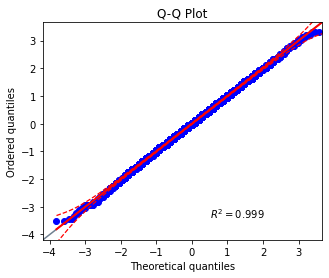

In [11]:
pg.qqplot(A)

<AxesSubplot:title={'center':'Q-Q Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

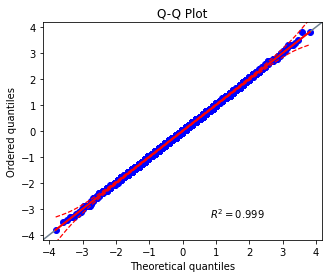

In [15]:
pg.qqplot(B)

<AxesSubplot:title={'center':'Q-Q Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

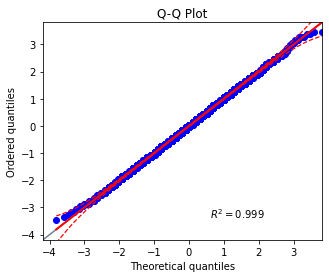

In [16]:
pg.qqplot(C)

<AxesSubplot:xlabel='group', ylabel='events'>

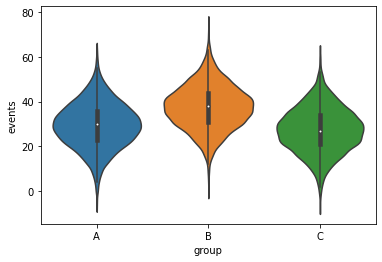

In [18]:
sns.violinplot(data=task_1_photo, x="group", y='events')

*нет оснований считать, что распределения ненормальны. Аналогично с гомогенностью дисперсий. Таким образом можно использовать параметрический тест ANOVA*

### Проверим гипотезу о том, что хотя бы одна пара имеет статистически значимое различие

<AxesSubplot:xlabel='group', ylabel='events'>

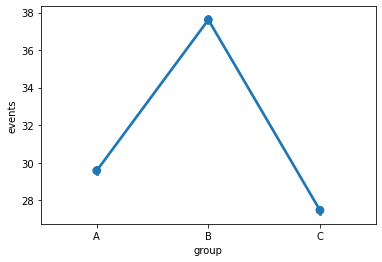

In [19]:
sns.pointplot(x='group', y='events', data = task_1_photo) # средние с доверительным интервалом. На глаз изменения стат. значимые

In [20]:
pg.anova(data=task_1_photo, dv = 'events', between = 'group') # есть стат. значимые различия

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,29997,2886.166657,0.0,0.161377


### Далее проверим, между какими группа есть различия. Для этого можно провести тест Тьюки

In [21]:
pg.pairwise_tukey(data=task_1_photo, dv = 'events', between = 'group')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.0,-0.806377
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.0,0.211712
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.0,1.018089


In [22]:
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
pairwise_tukeyhsd(task_1_photo.events, task_1_photo.group).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,8.034,-0.0,7.7038,8.3642,True
A,C,-2.1093,-0.0,-2.4395,-1.7791,True
B,C,-10.1433,-0.0,-10.4735,-9.8131,True


### Выводы
- *все 3 группы имеют статистически значимые различия*
- *в качестве картинок лучше использвать квадратный формат - группа B*

### Второй эксперимент.
была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый

### Описание данных

**5_task_2:**

- id – id клиента в эксперименте
- segment – сегмент (high/low)
- group – вид кнопки (control – старая версия, test – новая версия)
- events – сколько блюд суммарно было заказано за период

In [25]:
button = pd.read_csv(r'E:\Downloads\5_task_2.csv')
button.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [33]:
button.group.unique()

array(['test', 'control'], dtype=object)

In [45]:
button.segment.unique()

array(['high', 'low'], dtype=object)

In [27]:
button.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  int64  
 1   group    100000 non-null  object 
 2   segment  100000 non-null  object 
 3   events   100000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.1+ MB


In [29]:
button.duplicated().sum()

0

### В данном тесте необходимо использовать многофакторный ANOVA: первый фактор - цвет кнопки, второй - сегмент пользователей

### Посмотрим на данные. Для начала визуализируйте распределение events для контрольной и тестовой групп.

<AxesSubplot:xlabel='events', ylabel='Count'>

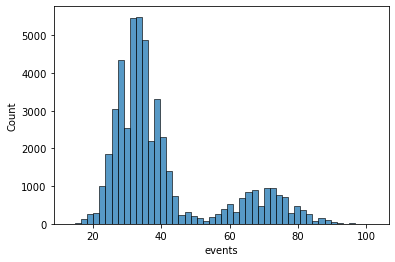

In [43]:
sns.histplot(button.query('group == "test"').events, bins=50)

<AxesSubplot:xlabel='events', ylabel='Count'>

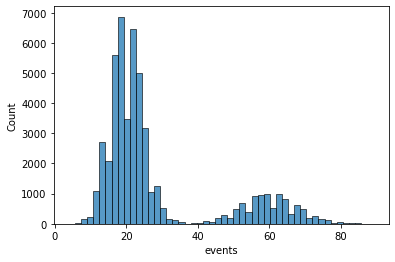

In [44]:
sns.histplot(data=button.query('group == "control"').events, bins=50)

### Посчитайте среднее, медиану и стандартное отклонение events в разбивке по группе и по сегменту пользователя. 

In [51]:
button.groupby(['group', 'segment']).events.describe()

count       mean       std   min   25%   50%   75%    max
group   segment                                                             
control high     10000.0  59.970800  7.805347  31.0  55.0  60.0  65.0   89.0
        low      40000.0  20.031575  4.473576   4.0  17.0  20.0  23.0   41.0
test    high     10000.0  69.938500  8.403974  40.0  64.0  70.0  76.0  102.0
        low      40000.0  33.025925  5.720845  13.0  29.0  33.0  37.0   59.0

### многофакторный дисперсионный анализ

<AxesSubplot:xlabel='group', ylabel='events'>

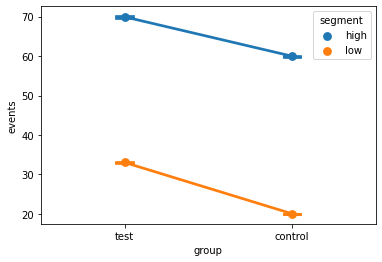

In [55]:
# проверим визуально различия
sns.pointplot(x='group', y='events', hue='segment', data=button, capsize=0.1)

*взаимодействия факторов наблюдается не так сильно (сильнее на сегменте low), но есть различие между контрольной и тестовой группой*

In [56]:
pg.anova(data=button, dv='events', between=['group', 'segment'])

,Source,SS,DF,MS,F,p-unc,np2
0,group,3.837195e+06,1.0,3.837195e+06,112031.864119,0.000000e+00,0.528383
1,segment,2.362480e+07,1.0,2.362480e+07,689756.377484,0.000000e+00,0.873383
2,group * segment,3.664244e+04,1.0,3.664244e+04,1069.823273,2.060261e-233,0.010585
3,Residual,3.424956e+06,99996.0,3.425093e+01,NaN,NaN,NaN


In [60]:
model = smf.ols(formula = "events ~ group*segment", data = button).fit() 
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
group,1.0,3.837195e+06,3.837195e+06,112031.864119,0.000000e+00
segment,1.0,2.362480e+07,2.362480e+07,689756.377484,0.000000e+00
group:segment,1.0,3.664244e+04,3.664244e+04,1069.823273,2.060261e-233
Residual,99996.0,3.424956e+06,3.425093e+01,NaN,NaN


*есть как стат значимые различия, так и взаимодействия факторов*

### используем критерий Тьюки, чтобы понять между какими группами есть статистически значимые различия.

### Выводы
- Фактор group оказался значимым, фактор segment – также значимым, их взаимодействие – тоже значимо. 
- Судя по графику, для всех групп среднее значение events увеличилось, поэтому решение - выкатываем новую версию